In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
import timm
from tqdm import tqdm
import os
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import json
from io import BytesIO
import requests
from copy import deepcopy
from astropy.nddata import Cutout2D

from matplotlib import rc
import matplotlib.ticker as tick

from rnn import *
from datasets import *
from torch.utils.data import DataLoader, random_split
from sklearn import metrics

import pandas as pd

In [2]:
set_random_seed(7)

## Смотрим сколько из скачанных объектов в фильтре r, g и i соответственно

In [3]:
oid_list = os.listdir('data')


In [4]:
bands = {'1':'g', '2':'r', '3':'i'}
bands_count = {'g':0, 'r':0, 'i':0}

In [5]:
for oid in oid_list:
    if len(oid)!= 15:
        bands_count[ bands[oid[4]] ] += 1
    else:
        bands_count[ bands[oid[3]] ] += 1

In [6]:
bands_count

{'g': 472, 'r': 2230, 'i': 0}

In [7]:
for oid in oid_list:
    if len(oid)!= 15:
        print(oid)

1824215400014323
1643112400006889
1824201100051760
1795111300000715
1795114100014267
1824207400036005
1592213200004836
1795107400030263
1637208400055014






## Распределение количества fits для одного объекта

In [8]:
def check_if_r(oid):
    if len(oid) != 15:
        return True if bands[oid[4]]=='r' else False

    else:
        return True if bands[oid[3]]=='r' else False

In [9]:
fits_count = []
r_oid_list = []
for oid in oid_list:
    if check_if_r(oid):
        fits_list = os.listdir(f'data/{oid}')
        fits_count.append(len(fits_list))
        r_oid_list.append(oid)

r_oid_list = np.array(r_oid_list)
fits_count = np.array(fits_count)


bucket_boundaries = [200, 400, 600, 800]

In [3]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=6, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=3, width=1.5)
    ax.xaxis.set_major_locator(tick.MultipleLocator(200))
    ax.xaxis.set_minor_locator(tick.MultipleLocator(100))
    #ax.yaxis.set_major_locator(tick.MultipleLocator(0.0005))

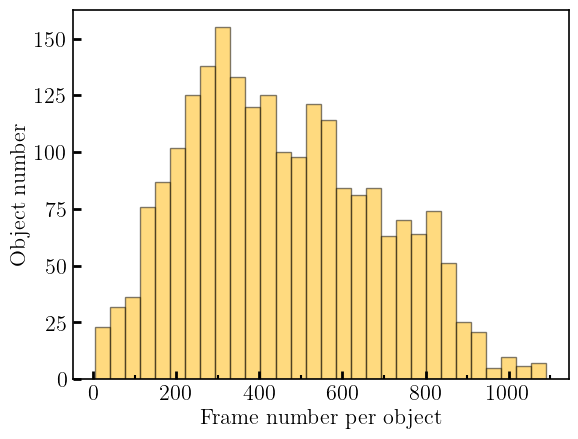

In [12]:
fig, ax = plt.subplots()
plt.hist(fits_count, bins=30, color='#FFB700', edgecolor='black', alpha=0.5)
plt.xlabel('Frame number per object')
presets_fig(ax)
#for bound in bucket_boundaries:
#    plt.axvline(x=bound, c='red')
#plt.text(2, 150, 'bucket:',
#        bbox={"facecolor": '#FFFFC2',
#                   "boxstyle": "square",
#                   "edgecolor": "#FBB117",
#             "alpha":0.5}, fontsize=12)
#plt.text(150, 150, r'\textbf{1}',)
#plt.text(250, 150, r'\textbf{2}',)
#plt.text(480, 150, r'\textbf{3}')
#plt.text(700, 150, r'\textbf{4}')
#plt.text(900, 150, r'\textbf{5}')
#plt.xlim(-50, 1125)
plt.ylabel('Object number')
plt.savefig('visualizations/seq_hist_simple.pdf', dpi=400, format='pdf')

In [14]:
labels = np.array(targets)
np.sum(labels==1)
np.sum(labels==0)


1080

## VAE RESULT

In [5]:
losses = np.load('trained_models/vae/loss_100ep.npy', allow_pickle='TRUE')
losses_aug = np.load('trained_models/vae/loss_aug.npy', allow_pickle='TRUE')
losses_78 = np.load('trained_models/vae/loss_ld78.npy', allow_pickle='TRUE')


In [6]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=8, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=5, width=1.5)
    #ax.xaxis.set_major_locator(tick.MultipleLocator(20))
    #ax.xaxis.set_minor_locator(tick.MultipleLocator(10))
    #ax.yaxis.set_major_locator(tick.MultipleLocator(0.0005))

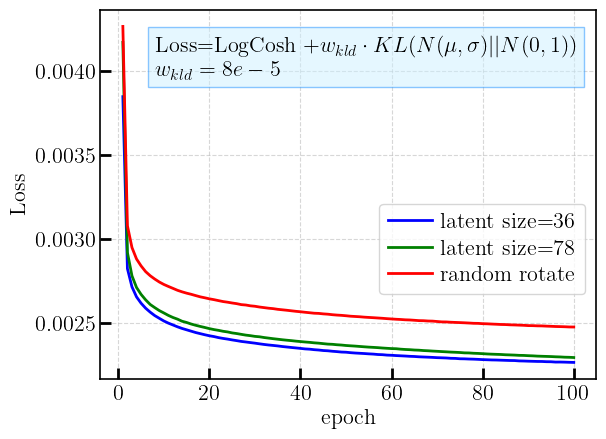

In [27]:
fig, ax = plt.subplots()
presets_fig(ax)
ax.plot(np.arange(1, len(losses)+1), losses, c='blue', label='latent size=36')
ax.plot(np.arange(1, len(losses_78)+1), losses_78, c='green', label='latent size=78')
ax.plot(np.arange(1, len(losses_aug)+1), losses_aug, c='red', label='random rotate')

ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.grid('on', linestyle='--', alpha=0.5)
#plt.text(10, 0.00388, f'Adam\nlearning rate=5e-5\nbatch size=256',
#        bbox={"facecolor": '#CDF0FF',
#                   "boxstyle": "square",
#                   "edgecolor": "#1E90FF",
#             "alpha":0.5})

ax.legend(loc='lower right', columnspacing=0.7, labelspacing=0.3,
               handletextpad=0.35, bbox_to_anchor=(1,0.2))
plt.text(8, 0.00397, 'Loss=LogCosh +' +
                     r'$w_{kld} \cdot KL(N(\mu, \sigma) || N(0, 1))$' + '\n' +
                     r'$w_{kld}=8e-5$',
         bbox={"facecolor": '#CDF0FF',
                   "boxstyle": "square",
                   "edgecolor": "#1E90FF",
             "alpha":0.5}
        )
plt.savefig('visualizations/vae_loss.pdf', dpi=400, format='pdf', bbox_inches="tight")

## RNN result

In [5]:
    def result_vis_test(path):
        fig, ax = plt.subplots(figsize=(10,5))
    #for i in range(5):
        presets_fig(ax)
        read_dictionary = np.load(f'{path}', allow_pickle='TRUE')
    
        train_loss = [read_dictionary[i]['train_loss'] for i, _ in enumerate(read_dictionary)]
        train_acc = [read_dictionary[i]['train_acc'] for i, _ in enumerate(read_dictionary)]

        test_loss = [read_dictionary[i]['test_loss'] for i, _ in enumerate(read_dictionary)]
        test_acc = [read_dictionary[i]['test_acc'] for i, _ in enumerate(read_dictionary)]

        test_prec = [read_dictionary[i]['test_prec'] for i, _ in enumerate(read_dictionary)]

        test_rec = [read_dictionary[i]['test_rec'] for i, _ in enumerate(read_dictionary)]
    
        n_epoch = len(test_rec)
    
        ax.grid('on', linestyle='--', alpha=0.5)
        ax.plot(np.arange(1, n_epoch + 1), train_loss, c='blue')
        ax.plot(np.arange(1, n_epoch + 1), test_loss, c='red')
        ax.set_ylabel('Loss')
        ax.legend(['train', 'test'])
        ax.set_xlabel('epoch')
        
        
        
        fig, ax = plt.subplots(figsize=(10,5))
        presets_fig(ax)
        ax.grid('on', linestyle='--', alpha=0.5)
        ax.plot(np.arange(1, n_epoch + 1), train_acc, c='blue')
        ax.plot(np.arange(1, n_epoch + 1), test_acc, c='red')
        ax.set_ylabel('Accuracy')
        ax.legend(['train', 'test'])
        ax.set_xlabel('epoch')

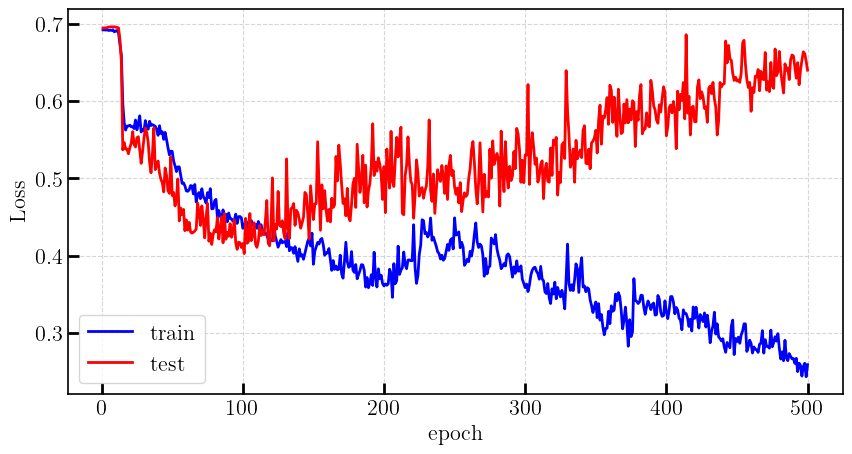

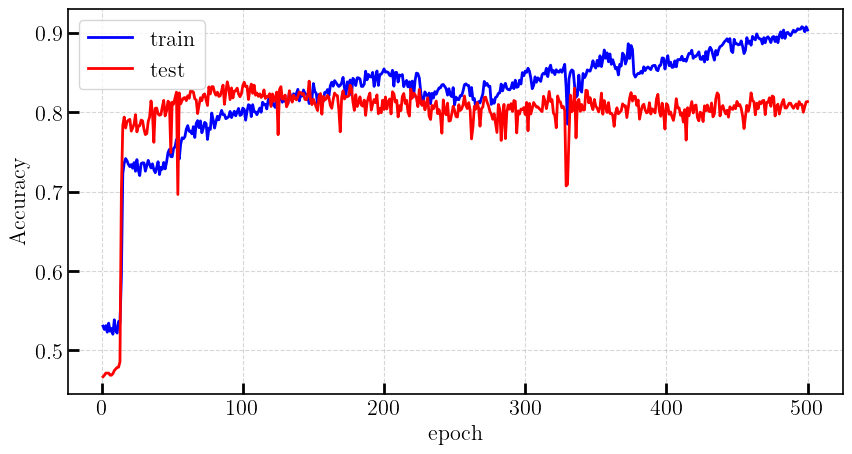

In [12]:
result_vis_test('trained_models/rnn/bceloss_300hs/result.npy')

In [3]:
oids, labels = get_only_r_oids('akb.ztf.snad.space.json')
data = EmbsSequenceData(oids, labels, label_type='float')

train, test = random_split(data, [0.8, 0.2])
result = {'roc_auc':[], 'tpr':[], 'fpr':[], 'f1':[],
              'thresholds':[], 'precision':[], 'recall':[],
              'accuracy':[]}
bucket_boundaries = [200, 400, 600, 800]
test_sampler = BySequenceLengthSampler(test, bucket_boundaries, 32, drop_last=False, shuffle=False)

test_loader = DataLoader(test, batch_size=1, 
                        batch_sampler=test_sampler, 
                        num_workers=4,
                        collate_fn=collate,
                        drop_last=False, pin_memory=False)



In [6]:
model = RBclassifier(hidden_size=300, rnn_type='GRU', out_size=1)
model.load_state_dict(torch.load(f'trained_models/rnn/bceloss_300hs/model.zip'))
model.eval()
out, gt = get_pred(model, test_loader)
fpr, tpr, thresholds = metrics.roc_curve(gt, out)
result['tpr'].append(tpr)
result['fpr'].append(fpr)
result['thresholds'].append(thresholds)
result['roc_auc'].append(metrics.roc_auc_score(gt, out))
f1scores = []
for tr in thresholds:
    current_predict = (out >=tr).long()
    f1scores.append(metrics.f1_score(gt, current_predict))
        #result['f1'].append(f1scores)
result['f1'].append(np.max(f1scores))
ind = np.argmax(f1scores)
cur_best_thr = result['thresholds'][-1][ind] #best thresholds for i fold
result['precision'].append(metrics.precision_score(gt, (out >= cur_best_thr).long()))
result['recall'].append(metrics.recall_score(gt, (out >= cur_best_thr).long()))
result['accuracy'].append(metrics.accuracy_score(gt, (out >= cur_best_thr).long()))

In [8]:
result['roc_auc']

[0.8190009675858733]

In [12]:
def result_vis(path):
    fig1, ax = plt.subplots(5, sharex=True, figsize=(10,15))
    for i in range(5):
        presets_fig(ax[i])
        read_dictionary = np.load(f'{path}{i}.npy', allow_pickle='TRUE')
    
        train_loss = [read_dictionary[i]['train_loss'] for i, _ in enumerate(read_dictionary)]
        train_acc = [read_dictionary[i]['train_acc'] for i, _ in enumerate(read_dictionary)]

        test_loss = [read_dictionary[i]['test_loss'] for i, _ in enumerate(read_dictionary)]
        test_acc = [read_dictionary[i]['test_acc'] for i, _ in enumerate(read_dictionary)]

        test_prec = [read_dictionary[i]['test_prec'] for i, _ in enumerate(read_dictionary)]

        test_rec = [read_dictionary[i]['test_rec'] for i, _ in enumerate(read_dictionary)]
    
        n_epoch = len(test_rec)
    
        presets_fig(ax[i])
        ax[i].grid('on', linestyle='--', alpha=0.5)
        ax[i].plot(np.arange(1, n_epoch + 1), train_loss, c='blue')
        ax[i].plot(np.arange(1, n_epoch + 1), test_loss, c='red')
        ax[i].set_ylabel('Loss')
        ax[i].legend(['train', 'test'])
        ax[i].set_xlabel('epoch')
    
    
    plt.savefig('visualizations/rnn_loss.pdf', dpi=400, format='pdf', bbox_inches="tight")
    
    

In [4]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=8, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=5, width=1.5)
    ax.xaxis.set_major_locator(tick.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tick.MultipleLocator(50))
    ax.yaxis.set_minor_locator(tick.MultipleLocator(0.05))

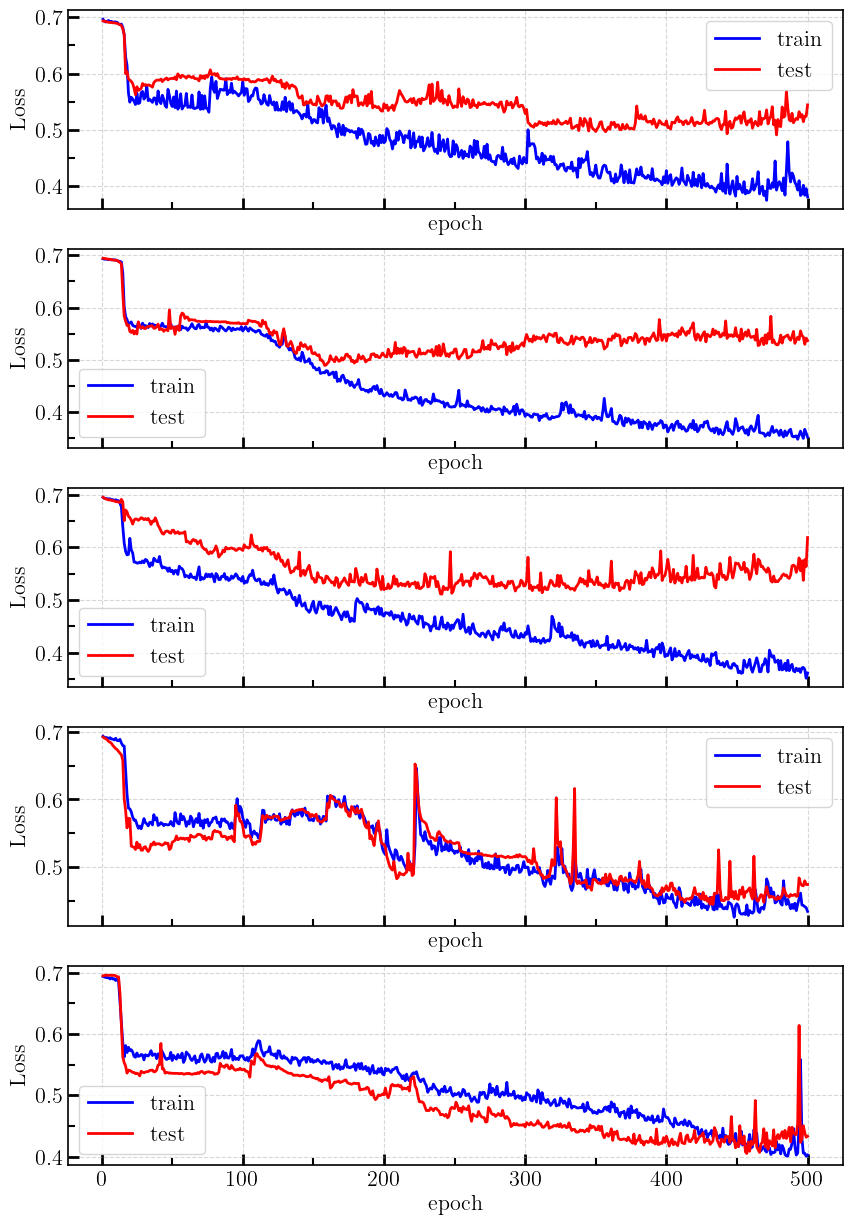

In [14]:
path = 'trained_models/rnn/kfold/baseline/result'
result_vis(path)

## KFOLD

In [4]:
@torch.inference_mode()
def get_pred(
             model,
             loader,
             ):
    if model.out_size == 2:
        result, gt = torch.zeros(1,2), torch.zeros(1)
        for x, label in loader:
            output = model(x)
            result = torch.vstack((result, output))
            gt = torch.hstack((gt, label))
        return nn.Softmax(dim=1)(result[1:])[:, 1], gt[1:]
    else:
        result, gt = torch.zeros(1), torch.zeros(1)
        for x, label in loader:
            output = model(x)
            result = torch.hstack((result, output))
            gt = torch.hstack((gt, label))    
        return result[1:], gt[1:]

In [7]:
oids, labels = get_only_r_oids('akb.ztf.snad.space.json')
data = EmbsSequenceData(oids, labels, label_type='float')

fold1, fold2, fold3, fold4, fold5 = random_split(data, [0.2, 0.2, 0.2, 0.2, 0.2])
folds = [fold1, fold2, fold3, fold4, fold5]

In [8]:
#output, labels = [], []
def get_result_kfold(model, model_name):
    result = {'roc_auc':[], 'tpr':[], 'fpr':[], 'f1':[],
              'thresholds':[], 'precision':[], 'recall':[],
              'accuracy':[]}
    bucket_boundaries = [200, 400, 600, 800]
    for k, fold in enumerate(folds):
    #concat_folds = ConcatDataset(folds[:k] + folds[k+1:])
    #train_sampler = BySequenceLengthSampler(concat_folds, bucket_boundaries, 32, drop_last=False, shuffle=True)
        test_sampler = BySequenceLengthSampler(fold, bucket_boundaries, 32, drop_last=False, shuffle=False)


    #train_loader = DataLoader(concat_folds, batch_size=1, 
    #                    batch_sampler=train_sampler, 
    #                    num_workers=16,
    #                    collate_fn=collate,
    #                    drop_last=False, pin_memory=False)

        test_loader = DataLoader(fold, batch_size=1, 
                        batch_sampler=test_sampler, 
                        num_workers=4,
                        collate_fn=collate,
                        drop_last=False, pin_memory=False)
        
        model.load_state_dict(torch.load(f'trained_models/rnn/kfold/{model_name}/model{k}.zip'))
        model.eval()
        out, gt = get_pred(model, test_loader)
        fpr, tpr, thresholds = metrics.roc_curve(gt, out)
        result['tpr'].append(tpr)
        result['fpr'].append(fpr)
        result['thresholds'].append(thresholds)
        result['roc_auc'].append(metrics.roc_auc_score(gt, out))
        f1scores = []
        for tr in thresholds:
            current_predict = (out >=tr).long()
            f1scores.append(metrics.f1_score(gt, current_predict))
        #result['f1'].append(f1scores)
        result['f1'].append(np.max(f1scores))
        ind = np.argmax(f1scores)
        cur_best_thr = result['thresholds'][-1][ind] #best thresholds for i fold
        result['precision'].append(metrics.precision_score(gt, (out >= cur_best_thr).long()))
        result['recall'].append(metrics.recall_score(gt, (out >= cur_best_thr).long()))
        result['accuracy'].append(metrics.accuracy_score(gt, (out >= cur_best_thr).long()))
    return result

In [9]:
model_names = ['baseline', 'tversky', 'wd_2dir', 'bceloss']
results = []
for name in model_names[:2]:
    model = RBclassifier(hidden_size=128, rnn_type='GRU', out_size=2)
    results.append(get_result_kfold(model, name))

model = RBclassifier(hidden_size=128, rnn_type='GRU', bidirectional=True, out_size=2)
results.append(get_result_kfold(model, model_names[2]))

model = RBclassifier(hidden_size=128, rnn_type='GRU', out_size=1)
results.append(get_result_kfold(model, model_names[3]))


In [10]:
print('-------------ROC AUC-------------')
for i, res in enumerate(results):
    print(f"{model_names[i]}:   {np.mean(res['roc_auc']):.3f} +- {np.std(res['roc_auc']):.3f}")
    
print('-------------Precision-------------')
for i, res in enumerate(results):
    print(f"{model_names[i]}:   {np.mean(res['precision']):.3f} +- {np.std(res['precision']):.3f}")


print('-------------Recall-------------')
for i, res in enumerate(results):
    print(f"{model_names[i]}:   {np.mean(res['recall']):.3f} +- {np.std(res['recall']):.3f}")

print('-------------Accuracy-------------')
for i, res in enumerate(results):
    print(f"{model_names[i]}:   {np.mean(res['accuracy']):.3f} +- {np.std(res['accuracy']):.3f}")

    
print('-------------F1-score-------------')
for i, res in enumerate(results):
    print(f"{model_names[i]}:   {np.mean(res['f1']):.3f} +- {np.std(res['f1']):.3f}")

-------------ROC AUC-------------
baseline:   0.838 +- 0.015
tversky:   0.841 +- 0.021
wd_2dir:   0.856 +- 0.010
bceloss:   0.834 +- 0.027
-------------Precision-------------
baseline:   0.788 +- 0.033
tversky:   0.817 +- 0.020
wd_2dir:   0.825 +- 0.037
bceloss:   0.790 +- 0.068
-------------Recall-------------
baseline:   0.786 +- 0.035
tversky:   0.769 +- 0.037
wd_2dir:   0.785 +- 0.019
bceloss:   0.783 +- 0.055
-------------Accuracy-------------
baseline:   0.779 +- 0.023
tversky:   0.791 +- 0.022
wd_2dir:   0.802 +- 0.023
bceloss:   0.772 +- 0.045
-------------F1-score-------------
baseline:   0.786 +- 0.014
tversky:   0.791 +- 0.016
wd_2dir:   0.804 +- 0.011
bceloss:   0.782 +- 0.023


## ALL

In [3]:
oids, labels = get_only_r_oids('akb.ztf.snad.space.json')
data = EmbsSequenceData(oids, labels)

train, test = random_split(data, [0.8, 0.2])

print('Making dataloaders..')
bucket_boundaries = [200, 400, 600, 800]
train_sampler = BySequenceLengthSampler(train, bucket_boundaries, 32, drop_last=False, shuffle=True)
test_sampler = BySequenceLengthSampler(test, bucket_boundaries, 32, drop_last=False, shuffle=False)


train_loader = DataLoader(train, batch_size=1, 
                        batch_sampler=train_sampler, 
                        num_workers=4,
                        collate_fn=collate,
                        drop_last=False, pin_memory=False)

test_loader = DataLoader(test, batch_size=1, 
                        batch_sampler=test_sampler, 
                        num_workers=4,
                        collate_fn=collate,
                        drop_last=False, pin_memory=False)

Making dataloaders..


In [5]:
model_names = ['baseline', 'tversky']

output, labels = [], []
for name in model_names:
    model = RBclassifier(hidden_size=128, rnn_type='GRU', out_size=2)
    model.load_state_dict(torch.load(f'trained_models/rnn/{name}/model.zip'))
    model.eval()
    out, gt = get_pred(model, test_loader)
    output.append(out)
    labels.append(gt)

model = RBclassifier(hidden_size=128, rnn_type='GRU', bidirectional=True, out_size=2)
model.load_state_dict(torch.load(f'trained_models/rnn/wd_2dir/model.zip'))
model.eval()
out, gt = get_pred(model, test_loader)
output.append(out)
labels.append(gt)

model = RBclassifier(hidden_size=128, rnn_type='GRU', out_size=1)
model.load_state_dict(torch.load(f'trained_models/rnn/bceloss/model.zip'))
model.eval()
out, gt = get_pred(model, test_loader)
output.append(out)
labels.append(gt)

model_names += ['wd_2dir', 'BCELoss']

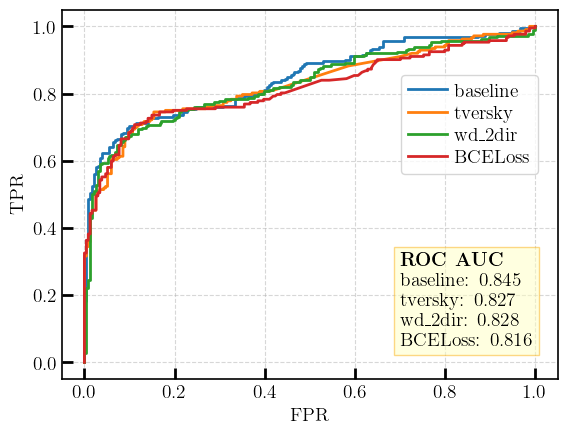

In [58]:
roc_auc = []
fig, ax = plt.subplots()
presets_fig(ax)
for i, name in enumerate(model_names):
    fpr, tpr, thresholds = metrics.roc_curve(labels[i], output[i])
    ax.plot(fpr, tpr, label=name)
    roc_auc.append(metrics.roc_auc_score(labels[i], output[i]))
ax.legend( columnspacing=0.7, labelspacing=0.25,
           handletextpad=0.35, 
          #loc='upper right'
          bbox_to_anchor=(0.98, 0.85),
         )
plt.text(0.7, 0.05, r"\textbf{ROC AUC}" + 
                     f'\n{model_names[0]}: {roc_auc[0]:.3f}\n' + 
                     f'{model_names[1]}: {roc_auc[1]:.3f}\n' +
                     f'{model_names[2]}: {roc_auc[2]:.3f}\n' +
                     f'{model_names[3]}: {roc_auc[3]:.3f}',
        bbox={"facecolor": '#FFFFC2',
                   "boxstyle": "square",
                   "edgecolor": "#FBB117",
             "alpha":0.5})
ax.grid('on', linestyle='--', alpha=0.5)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.savefig('visualizations/roc_curves.pdf', dpi=400, format='pdf', bbox_inches="tight")

## Artefacts imgs

In [185]:
import imageio
from PIL import ImageDraw, Image, ImageFont

In [207]:
oid = 643111200013087

In [187]:
#font = ImageFont.truetype("arial.ttf", 1)
def imgs_count(path):
    frames = []
    frame_names = sorted(os.listdir(path))
    for i, name in enumerate(frame_names):
        with fits.open(f'{path}/{name}') as f:
            frame = img_prep(f)
            with Image.fromarray(frame) as imgPil:
                d = ImageDraw.Draw(imgPil)
                d.text((1,0), f"{i}")
                frames.append(imgPil)
            del d, imgPil

    return frames

In [188]:
fr = imgs_count(f'data/{oid}')
imageio.mimsave(f'gifs/{oid}.gif', # output gif
                fr,          # array of input frames
                fps = 10)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [189]:
from IPython.display import display, Image
Image(f'gifs/{oid}.gif', width=300, height=300)

In [208]:
norm_frames = get_frames_seq(f'data/{oid}')

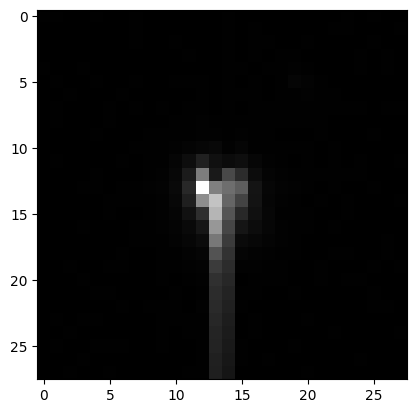

In [209]:
plt.imshow(norm_frames[311].view(28,28), cmap='gray')

In [210]:
np.save('visualizations/artefact_img/column2.npy', norm_frames[311].view(28,28).numpy())

In [197]:
mjds = sorted(os.listdir(f'data/{oid}'))

In [111]:
print(f'defocusing   data/{oid}/{mjds[704]}')

defocusing   data/682201300017788/59266.52548306761.fits


In [121]:
print(f'track   data/{oid}/{mjds[128]}')

track   data/678216100007149/58283.22827018332.fits


In [129]:
print(f'ghost   data/{oid}/{mjds[350]}')

ghost   data/635209100001425/58389.2129856525.fits


In [144]:
print(f'column   data/{oid}/{mjds[651]}')

column   data/683111200004107/58767.21649809042.fits


In [177]:
print(f'track2   data/{oid}/{mjds[107]}')

track2   data/718115100010649/58258.466378265526.fits


In [198]:
print(f'column2   data/{oid}/{mjds[311]}')

column2   data/643111200013087/58706.43707652902.fits


## ----

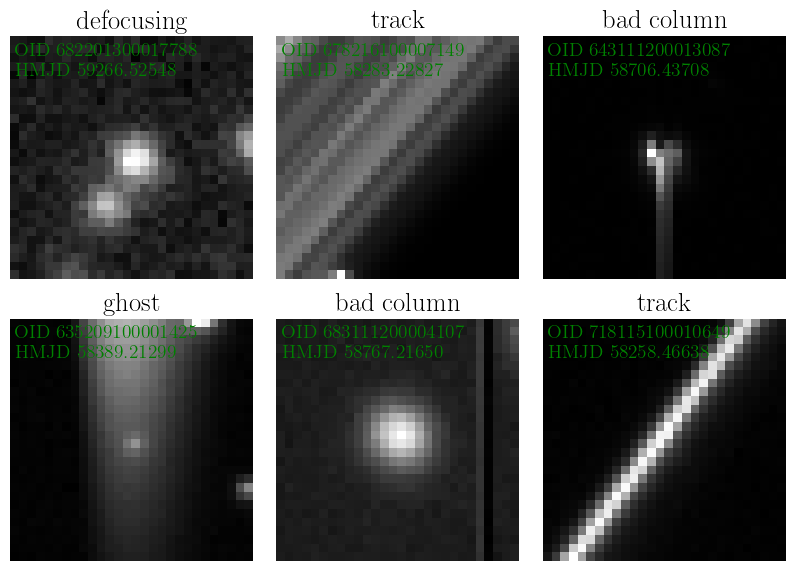

In [52]:
art_name = ['defocusing', 'track', 'ghost', 'column', 'track2', 'column2']
oids = [682201300017788, 678216100007149, 635209100001425, 683111200004107, 718115100010649, 643111200013087]
hmjds = [59266.52548306761, 58283.22827018332, 58389.2129856525, 58767.21649809042, 58258.466378265526, 58706.43707652902]
fig, axs = plt.subplot_mosaic([['defocusing', 'track', 'column2'],
                               ['ghost', 'column', 'track2']], figsize=(10, 7))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
cool = {'defocusing':'defocusing', 'track':'track', 'track2':'track', 'column':'bad column',
       'column2':'bad column', 'ghost':'ghost'}
for i, bogus in enumerate(art_name):
    img = np.load(f'visualizations/artefact_img/{bogus}.npy')
    axs[bogus].imshow(img, cmap='gray')
    axs[bogus].axis('off')
    axs[bogus].set_title(cool[bogus])
    axs[bogus].text(0.1, 4, f'OID {oids[i]} \n HMJD {hmjds[i]:.5f}',
         color='green', fontsize=14
        )
plt.savefig('visualizations/artfs.pdf', dpi=400, format='pdf', bbox_inches="tight")

## ROC-AUC average curves for different models

In [6]:
def presets_fig(ax):
    rc('text', usetex=True)
    font = {'family' : 'Times New Roman',
    #'weight' : 1000,
    'size'   : 16}
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rc('font', **font)
    plt.rcParams['lines.linewidth'] = 2

    ax.tick_params(axis='both', direction='in', which='major',  length=8, width=2)
    ax.tick_params(axis='both', direction='in', which='minor',  length=5, width=1.5)
    ax.xaxis.set_major_locator(tick.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tick.MultipleLocator(50))
    ax.yaxis.set_minor_locator(tick.MultipleLocator(0.05))

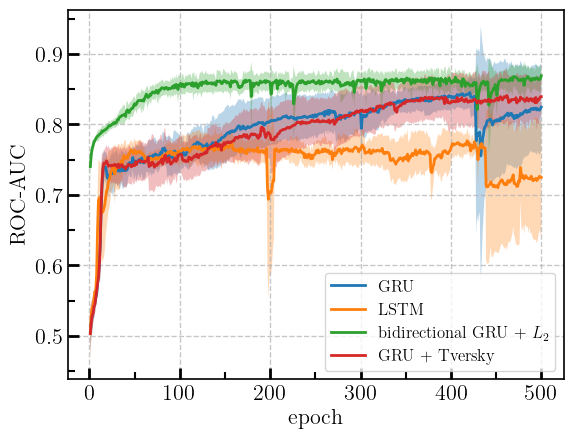

In [8]:
models = ['baseline', 'lstm', 'wd_2dir', 'tversky']
cool_names = ['GRU', 'LSTM', 'bidirectional GRU $+~L_2$', 'GRU $+$ Tversky']

fig, ax = plt.subplots()
presets_fig(ax)
for mod, name in zip(models,cool_names):
    values = []
    for i in range(5):
        table = pd.read_csv(f'model_metrics/ROC-AUC/{mod}_fold{i}_ROC-AUC_test.csv', sep=",")
        values.append(table['Value'].tolist())
    values = np.array(values)
    ax.plot(np.arange(1, 501), np.mean(values, axis=0), label=name)
    ax.fill_between(np.arange(1, 501),
                        np.mean(values, axis=0) + np.std(values, axis=0),
                        np.mean(values, axis=0) - np.std(values, axis=0),
                        alpha=0.3)
ax.grid('on', linestyle='--', alpha=0.7, linewidth=1)
ax.legend(fontsize=12)
ax.set_xlabel('epoch')
ax.set_ylabel('ROC-AUC')

plt.savefig('visualizations/roc_auc.pdf', dpi=400, format='pdf', bbox_inches="tight")

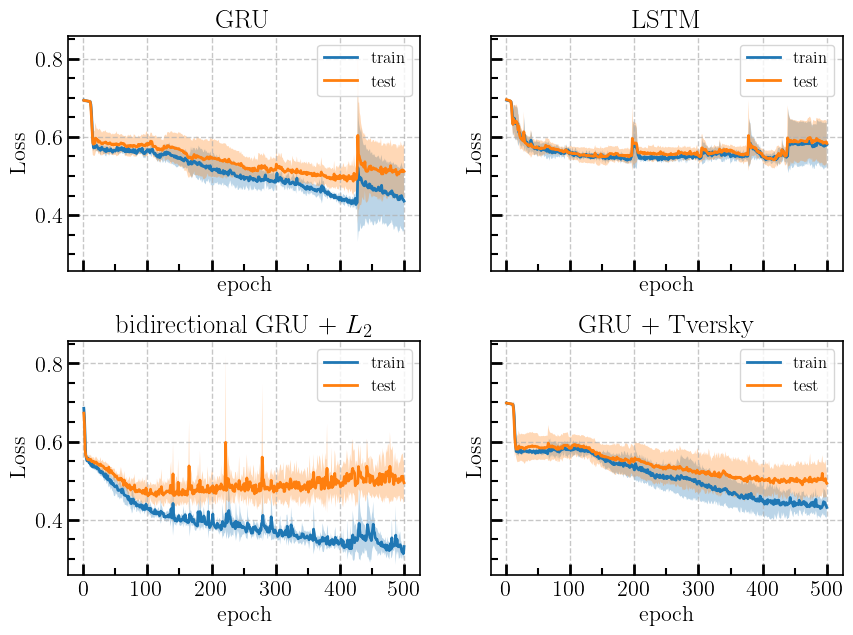

In [10]:
models = ['baseline', 'lstm', 'wd_2dir', 'tversky']
cool_names = ['GRU', 'LSTM', 'bidirectional GRU $+~L_2$', 'GRU $+$ Tversky']

fig, axs = plt.subplot_mosaic([['baseline', 'lstm'], ['wd_2dir', 'tversky']], sharex=True, sharey=True, figsize=(10, 7))
for mod, name in zip(models, cool_names):
    presets_fig(axs[mod])
    test_values, train_values = [], []
    for i in range(5):
        table = pd.read_csv(f'model_metrics/Loss/{mod}_fold{i}_Loss_test.csv', sep=",")
        test_values.append(table['Value'].tolist())

        table = pd.read_csv(f'model_metrics/Loss/{mod}_fold{i}_Loss_train.csv', sep=",")
        train_values.append(table['Value'].tolist())
        
    test_values, train_values = np.array(test_values), np.array(train_values)
    axs[mod].plot(np.arange(1, 501), np.mean(train_values, axis=0), label='train')
    axs[mod].fill_between(np.arange(1, 501),
                        np.mean(train_values, axis=0) + np.std(train_values, axis=0),
                        np.mean(train_values, axis=0) - np.std(train_values, axis=0),
                        alpha=0.3)

    axs[mod].plot(np.arange(1, 501), np.mean(test_values, axis=0), label='test')
    axs[mod].fill_between(np.arange(1, 501),
                        np.mean(test_values, axis=0) + np.std(test_values, axis=0),
                        np.mean(test_values, axis=0) - np.std(test_values, axis=0),
                        alpha=0.3)
    
    axs[mod].grid('on', linestyle='--', alpha=0.7, linewidth=1)
    axs[mod].legend(fontsize=12)
    axs[mod].set_xlabel('epoch')
    axs[mod].set_ylabel('Loss')
    axs[mod].set_title(name)

fig.subplots_adjust(hspace=0.3)
plt.savefig('visualizations/rnn_losses.pdf', dpi=400, format='pdf', bbox_inches="tight")